In [1]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn.functional as F     # Contains all the functions in the torch.nn library
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [4]:
def train(inputDataLoader,model,loss_function,optimizer,epochNumber):
    
    model.train()
    acccs=[]
    loss_array=[]
    for (inputs,label) in inputDataLoader:
        label=label.to(device)
        inputs = inputs.reshape(-1, 28*28).to(device)
        output=model.forward(inputs)
        loss=loss_function(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = label.detach().cpu().numpy()
        # measure accuracy and record loss
        acc1 = accuracy(preds, labels)
        acccs.append(acc1)
    return np.mean(loss_array)

In [5]:
def test(inputDataLoader,model,loss_function,optimizer):
    model.eval()
    output_result=[]
    loss_result=[]
    acccs=[]

    with torch.no_grad():
        for (inputs,label) in inputDataLoader:
            inputs = inputs.reshape(-1, 28*28).to(device)
            label=label.to(device)
            output=model.forward(inputs)
            loss=loss_function(output,label)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = label.detach().cpu().numpy()
            # measure accuracy and record loss
            acc1 = accuracy(preds, labels)
            acccs.append(acc1)


In [6]:

class NeuralNet(torch.nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=600)
        self.activ1=nn.ReLU()
        self.fc2 = nn.Linear(in_features=600, out_features=500)     
        self.activ2=nn.ReLU()
        self.fc3 = nn.Linear(in_features=500, out_features=250)  
        self.activ3=nn.ReLU() 
        self.fc4=nn.Linear(in_features=250, out_features=10) 
        
    def forward(self, x):
        x = self.fc1(x)   
        x = self.activ1(x)
        x = self.fc2(x)        
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x=self.fc4(x)
        return x 

In [7]:
def initMNIST(batch_size_train,batch_size_test):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)
    return train_loader,test_loader

In [8]:
train_loader,test_loader=initMNIST(256,256)
epochs=12

final_model_list=[]
final_layer_list=[]
for i in range(0,8,1):
    model=NeuralNet()
    model.to(device)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(), lr = 1e-2)
    model_list=[]
    layer_list=[]
    for epoch in range(0,epochs):
        train(train_loader,model,criterion,optimizer,epoch)
        if epoch%3==0:
            w1=torch.flatten(model.fc1.weight)
            w2=torch.flatten(model.fc2.weight)
            w3=torch.flatten(model.fc3.weight)
            w4=torch.flatten(model.fc4.weight)
            model_list.append(torch.cat((w1,w2,w3,w4),0))
            layer_list.append(w1)
        test(test_loader,model,criterion,optimizer)
    final_model_list.append(torch.stack(model_list))
    final_layer_list.append(torch.stack(layer_list))



/home/nkulshr/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkulshr/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
final_layer_list

[tensor([[0.0809, 0.0448, 0.0489,  ..., 0.0967, 0.0908, 0.0754],
         [0.0809, 0.0448, 0.0489,  ..., 0.0967, 0.0908, 0.0754],
         [0.0809, 0.0448, 0.0489,  ..., 0.0967, 0.0908, 0.0754],
         [0.0809, 0.0448, 0.0489,  ..., 0.0967, 0.0908, 0.0754]],
        device='cuda:0', grad_fn=<StackBackward0>),
 tensor([[0.0647, 0.0098, 0.0425,  ..., 0.0637, 0.0407, 0.0438],
         [0.0647, 0.0098, 0.0425,  ..., 0.0637, 0.0407, 0.0438],
         [0.0647, 0.0098, 0.0425,  ..., 0.0637, 0.0407, 0.0438],
         [0.0647, 0.0098, 0.0425,  ..., 0.0637, 0.0407, 0.0438]],
        device='cuda:0', grad_fn=<StackBackward0>),
 tensor([[0.0641, 0.0637, 0.0793,  ..., 0.0715, 0.0407, 0.0457],
         [0.0641, 0.0637, 0.0793,  ..., 0.0715, 0.0407, 0.0457],
         [0.0641, 0.0637, 0.0793,  ..., 0.0715, 0.0407, 0.0457],
         [0.0641, 0.0637, 0.0793,  ..., 0.0715, 0.0407, 0.0457]],
        device='cuda:0', grad_fn=<StackBackward0>),
 tensor([[0.0534, 0.0483, 0.1024,  ..., 0.0362, 0.0655, 0.056

In [10]:
events_weights = np.array([y.detach().cpu().numpy() for x in final_model_list for y in x])

In [11]:
events_weights.shape

(32, 897900)

In [12]:
pca = PCA(n_components=2)
result = pca.fit_transform(events_weights)

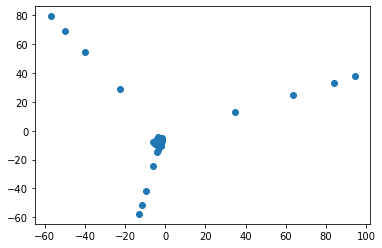

In [13]:
plt.scatter(result[:,0],result[:,1])
plt.savefig("pca.png")

In [14]:
# a=final_model_list[0]
# num=a.cpu().detach().numpy()
# print(num)
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(num)
# print(principalComponents)

In [15]:
df = pd.DataFrame(result, columns = ['PCA_1','PCA_2'])
df["round"]=""
for i in range(0,len(df),1):
    df.iloc[i,df.columns.get_loc('round')] =math.floor(i/4)

In [16]:
df

,PCA_1,PCA_2,round
0,-2.493421,-7.165273,0
1,-3.349265,-10.788518,0
2,-3.849469,-13.396873,0
3,-4.328407,-14.872032,0
4,34.615971,12.993254,1
5,63.554230,24.890436,1
6,83.902260,33.288097,1
7,94.489410,37.734230,1
8,-1.864594,-6.009331,2
9,-2.119537,-8.084666,2


[0, 1, 2, 3, 4, 5, 6, 7]


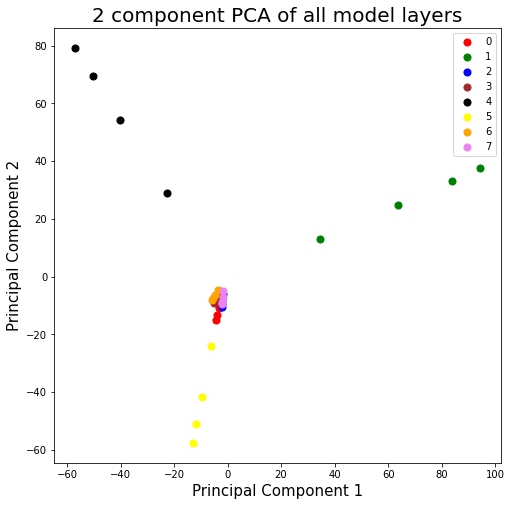

In [17]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of all model layers', fontsize = 20)
targets=[]
for i in range(0,8,1):
    targets.append(i)
print(targets)
colors=['red','green','blue','brown','black','yellow','orange','violet']
for target, color in zip(targets,colors):
    indicesToKeep = df['round'] == target
    ax.scatter(df.loc[indicesToKeep, 'PCA_1']
               , df.loc[indicesToKeep, 'PCA_2']
               , c = color
               , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.savefig('pca_model.png')


In [18]:
events_weights = np.array([y.detach().cpu().numpy() for x in final_layer_list for y in x])

In [20]:
pca = PCA(n_components=2)
result = pca.fit_transform(events_weights)

In [22]:
df = pd.DataFrame(result, columns = ['PCA_1','PCA_2'])


In [23]:
df

,PCA_1,PCA_2
0,-3.868256,-8.702147
1,-3.868251,-8.702144
2,-3.868251,-8.702133
3,-3.868252,-8.702128
4,76.294205,20.366987
5,76.294189,20.366983
6,76.294197,20.366983
7,76.294189,20.366983
8,-0.795880,-4.191319
9,-0.795880,-4.191319


In [24]:
df["round"]=""
for i in range(0,len(df),1):
    df.iloc[i,df.columns.get_loc('round')] =math.floor(i/4)

[0, 1, 2, 3, 4, 5, 6, 7]


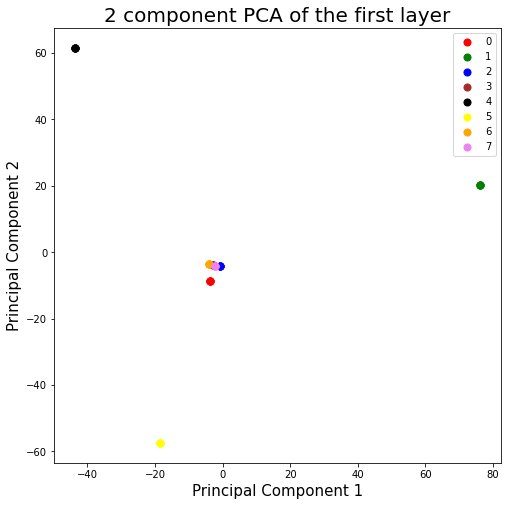

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of the first layer', fontsize = 20)
targets=[]
for i in range(0,8,1):
    targets.append(i)
print(targets)
colors=['red','green','blue','brown','black','yellow','orange','violet']
for target, color in zip(targets,colors):
    indicesToKeep = df['round'] == target
    ax.scatter(df.loc[indicesToKeep, 'PCA_1']
               , df.loc[indicesToKeep, 'PCA_2']
               , c = color
               , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.savefig('pca_layer.png')
